# Práctica 1: Resolución de Problemas con Algoritmos de Búsqueda
## Problema de Búsqueda
### Inteligencia Artificial en la Investigación Operativa

En este cuaderno vamos a plantear, diseñar y resolver los ejercicios 1-4 para el primer problema de la relación del guión de la Práctica 1.

#### Problema 1. Problema de búsqueda.

Un problema paradigmático resoluble a través de algoritmos de búsqueda es encontrar la ruta óptima que un robot debe seguir a través de un tablero para llegar desde una casilla inicial (marcada en azul) a una casilla final (marcada en verde) previamente establecidas. El tablero puede incluir obstáculos (casillas que el robot no puede atravesar), tal como se muestra en la Figura 1.

|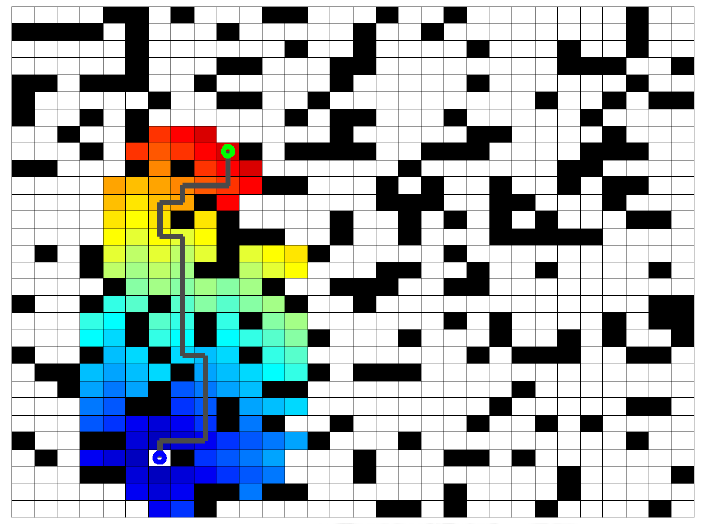|
|:--:|
| **Figura 1**: Problema de Búsqueda.|


##### Actividad 1. Planteamiento del problema

El objetivo de la primera actividad es analizar el problema y plantear su modelo. Para ello tenemos que responder primeramente a la pregunta:

> ¿Estamos ante un problema de búsqueda?

Para ello tenemos que saber el **objetivo** a alcanzar y si el problema tiene algún tipo de **restricción**. En este caso, tenemos

 1. **Objetivo**. Encontrar la mejor ruta desde un punto de origen a un punto de destino.
 2. **Restricciones**. Salvar los obstáculos existentes.
 
Por tanto, estamos ante un problema resoluble con un algoritmo de búsqueda, dado que tenemos un objetivo a conseguir y un conjunto de restricciones que respetar.

La siguiente tarea diseñar el modelo o mundo relativo al problema. Para ello vamos a identificar los elementos esenciales de un problema de búsqueda en nuestro caso particular:

 * **Estado**. Representando el espacio de posiciones del angente como una _cuadrícula_, cada estado del agente será su posición en una de estas cudrículas.
 * **Estado inicial**. Posición inicial del agente en el espacio de estados (_cuadrícula_).
 * **Acciones**.
  * ARRIBA.
  * ABAJO.
  * IZQUIERDA.
  * DERECHA.
 * **Modelo de transición**. El agente cambiará de posición (estado - cuadrícula) según la acción realizada. Si la acción es ARRIBA, el agente se moverá hacia la posición justo que tiene por encima de él en la cuadrícula. Si la acción es IZQUIERDA, el agente se moverá para la iquierda una posición. Cada acción implica un cambio de estado.
 * **Estado objetivo**. El objetivo final al que hay que llegar. En nuestro caso es la casilla a la que el agente debe llegar.
 * **Restricciones**. El agente no puede pasar por las casillas marcadas como obstáculos, es decir, son estados inalcanzables por el agente.


##### Resolución

A continuación se muestra la resolución del problema con varios algoritmos de búsqueda vistos en la parte de teoría de la asignatura, y que se corresponden con la _Actividad 2_ (búsqueda en profundidad), _Actividad 3_ (búsqueda en anchura) y _Actividad 4_ (búsqueda de coste uniforme).

La resolución se realiza con el lenguaje de programación Python, y tomando como base el repositorio [AIMA-Python](https://github.com/aimacode/aima-python), que está asociado al libro:

>Russell, S. y Norving, P. Artificial Intelligence. A Modern Approach. Pearson. Fourth Edition. Global Edition. 2022.

Vamos a empezar primeramente con la definición del conjunto de accioens.

In [1]:
from enum import Enum, unique
@unique
class Directions(Enum):
 
    UP=(0,1)
    DOWN=(0,-1)
    RIGHT=(1,0)
    LEFT=(-1,0)

Ahora vamos a definir nuestro problema de búsqueda, que dado que lo hemos modelado como una cuadrícula de estados, vamos a definir una clase de modelo/mundo basado en cuadrícula

In [2]:
# %load -r 12,15-18,30-118 grid_search_problems.py
from search import *
import matplotlib.pyplot as plt
import heuristics
import math
import utils4e
class GridProblem(Problem):
    '''
    classdocs
    '''


    def __init__(self, initial=None, goal=None, obstacles=(), **kwds):
        '''
        Constructor
        '''
        Problem.__init__(self, initial, goal=goal,
                         obstacles=set(obstacles) - {initial, goal}, **kwds)
        
        self.__directions = [Directions.__members__[k].value for k in Directions.__members__.keys()]
        self.__failure = Node('FALLO', path_cost=math.inf) #Nodo que indica que
                        #indica que el algoritmo no encuentra solución al problema
        self.__cutoff = Node('INTERRUMPIDO', path_cost=math.inf) #Nodo que indica
                    #que el algoritmo de búsqueda en profundidad se ha
                        #interrumpido.
    def is_goal(self, state):
        return Problem.is_goal(self, state)

                        

    def action_cost(self, s, a, s1):
        return heuristics.straight_line_distance(s, s1)


    def h(self, node):
        return heuristics.straight_line_distance(node.state, self.goal)


    def actions(self, state):
        """All the actions that can do
        
        state:
            The current state (it is a node).
            
        Returns:
            A dictionary with the following positions.
        """
        #inline: {(x + self.__directions.__members__[k],y + self.__directions.__members__[k])[1]for k in self.__directions.__members__.keys()}
        x, y = state
        next_states = set()
        for d in self.__directions:
            next_states.add((x + d[0], y + d[1]))
        
        #It is a difference among sets. All the possible actions except the obstacles.
        
        return  next_states - self.obstacles


    def result(self, state, action):
        return action if action not in self.obstacles else state



    def path_cost(self, c, state1, action, state2):
        return Problem.path_cost(self, c, state1, action, state2)


    def value(self, state):
        return Problem.value(self, state)
    
    def plot_grid_problem(self, solution, title='Search', show=True):
        """It plots a grid problem.
        
        Args:
            grid:
            solution:
            reached:
            title:
            show: Boolean value that determines whether the plot must be showed
            or not.
        
        """
        plt.figure(figsize=(16, 10))
        plt.axis('off')
        plt.axis('equal')
        plt.scatter(*transpose(self.obstacles), marker='s', color='darkgrey')
        plt.scatter(*transpose(self.explored), marker='.', c='blue')
        plt.scatter(*transpose(solution.path_states()), marker='s', c='blue')
        plt.scatter(*transpose([self.initial]), 9**2, marker='D', c='green')
        plt.scatter(*transpose([self.goal]), 9**2, marker='D', c='red')
        if show: plt.show()
        print('{} {} search: {:.1f} path cost, {:,d} states reached'
          .format(' ' * 10, title, solution.path_cost, len(self.explored)))
        


El proceso de búsqueda lo vamos a representar como una exploración en un árbol/grafo. Ya trabajemos con un árbol o con un grafo, necesitamos representar su elemento de información, el nodo. A continuación el código de la clase nodo.

In [3]:
# %load -r 100-176 search.py
class Node:
    """A node in a search tree. Contains a pointer to the parent (the node
    that this is a successor of) and to the actual state for this node. Note
    that if a state is arrived at by two paths, then there are two nodes with
    the same state. Also includes the action that got us to this state, and
    the total path_cost (also known as g) to reach the node. Other functions
    may add an f and h value; see best_first_graph_search and astar_search for
    an explanation of how the f and h values are handled. You will not need to
    subclass this class."""

    def __init__(self, state, parent=None, action=None, path_cost=0):
        """Create a search tree Node, derived from a parent by an action."""
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
        self.depth = 0
        if parent:
            self.depth = parent.depth + 1

    def __repr__(self):
        return "<Node {}>".format(self.state)

    def __lt__(self, node):
        return self.state < node.state

    
    def expand(self, problem):
        """List the nodes reachable in one step from this node."""
        return [self.child_node(problem, action)
                for action in problem.actions(self.state)]

    def child_node(self, problem, action):
        """[Figure 3.10]"""
        next_state = problem.result(self.state, action)
        next_node = Node(next_state, self, action, problem.path_cost(self.path_cost, self.state, action, next_state))
        return next_node

    def solution(self):
        """Return the sequence of actions to go from the root to this node."""
        return [node.action for node in self.path()[1:]]

    def path(self):
        """Return a list of nodes forming the path from the root to this node."""
        node, path_back = self, []
        while node:
            path_back.append(node)
            node = node.parent
        return list(reversed(path_back))
    
    def path_states(self):
        """Return a list of nodes states.
        """
        node, path_back = self, []
        while node:
            path_back.append(node.state)
            node = node.parent
        return list(reversed(path_back))
        

    # We want for a queue of nodes in breadth_first_graph_search or
    # astar_search to have no duplicated states, so we treat nodes
    # with the same state as equal. [Problem: this may not be what you
    # want in other contexts.]

    def __eq__(self, other):
        return isinstance(other, Node) and self.state == other.state

    def __hash__(self):
        # We use the hash value of the state
        # stored in the node instead of the node
        # object itself to quickly search a node
        # with the same state in a Hash Table
        return hash(self.state)
    
    def __len__(self): return 0 if self.parent is None else (1 + len(self.parent))


###### Algoritmo de búsqueda en profundidad

El algoritmo de búsqueda en profundidad realiza un recorrido en profundida del árbol/grafo de estados. Más concretamente, en cada estado (nodo) aplica las posibles acciones y selecciona el estado (nodo) más a la izquierda para continuar la exploración. También se puede decir que procesa los nuevos estados en forma de una pila o cola LIFO (_last in, first out_). En la siguiente imagen se puede ver un ejemplo.

|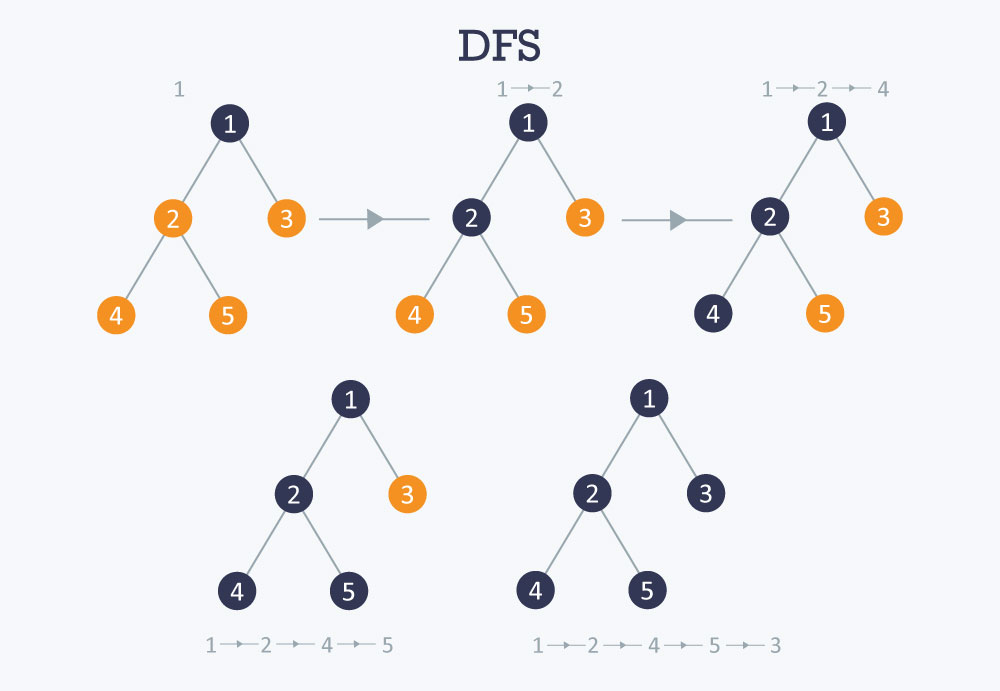|
|:--:|
| **Figura 2**: Búsqueda en profundidad.|

In [4]:
# %load -r 263-284 search.py
def depth_first_graph_search(problem):
    """
    [Figure 3.7]
    Search the deepest nodes in the search tree first.
    Search through the successors of a problem to find a goal.
    The argument frontier should be an empty queue.
    Does not get trapped by loops.
    If two paths reach a state, only use the first one.
    """
    frontier = [(Node(problem.initial))]  # Stack

    explored = set()
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            problem.explored = explored
            return node
        explored.add(node.state)
        frontier.extend(child for child in node.expand(problem)
                        if child.state not in explored and child not in frontier)
    return None


###### Búsqueda en Anchura

El algoritmo de búsqueda en anchura realiza un recorrido en anchura del árbol/grafo de estados. Más concretamente, en cada estado (nodo) aplica las posibles acciones y obtiene los nuevos estados. Estos estados son explorados en el mismo orden de creación. Se puede decir que los estados (nodos) se procesn según una cola o cola FIFO (_first in, first out_).

|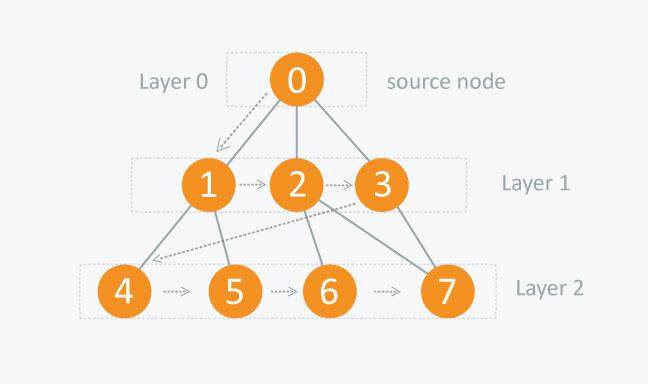|
|:--:|
|**Figura 3**: Búsqueda en anchura|

In [5]:
# %load -r 286-319 search.py
def breadth_first_graph_search(problem):
    """The search algorithm tracks in the explored variables the nodes reached
    during the search.
    
    Original comment from Ed3 of the book: [Figure 3.11]
    Note that this function can be implemented in a
    single line as below:
    return graph_search(problem, FIFOQueue())
    
    
    Args:
        problem: A Problem object that represents the problem to be resolve.
    
    Returns:
        The goal node in case the problem has a solution and the set of explored
        nodes. Failure Node.
    """
    node = Node(problem.initial)
    if problem.is_goal(node.state):
        problem.explored = set(node.state)
        return node
    frontier = deque([node])
    explored = set()
    while frontier:
        node = frontier.popleft()
        explored.add(node.state)
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                if problem.is_goal(child.state):
                    problem.explored=explored
                    return child
                frontier.append(child)
    return None


###### Coste uniforme

El algoritmo de búsqueda de coste uniforme selecciona es ya un algoritmo de búsqueda con información que emplea una función heurística para determinar el estado más cerecano o con menor coste al estado (nodo) objetivo.


In [6]:
# %load -r 321-355 search.py
def best_first_graph_search(problem, f, display=False):
    """Search the nodes with the lowest f scores first.
    You specify the function f(node) that you want to minimize; for example,
    if f is a heuristic estimate to the goal, then we have greedy best
    first search; if f is node.depth then we have breadth-first search.
    There is a subtlety: the line "f = memoize(f, 'f')" means that the f
    values will be cached on the nodes as they are computed. So after doing
    a best first search you can examine the f values of the path returned."""
    f = memoize(f, 'f')
    node = Node(problem.initial)
    frontier = PriorityQueue('min', f)
    frontier.append(node)
    explored = set()
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            if display:
                print(len(explored), "paths have been expanded and", len(frontier), "paths remain in the frontier")
            problem.explored = explored
            return node
        explored.add(node.state)
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                frontier.append(child)
            elif child in frontier:
                if f(child) < frontier[child]:
                    del frontier[child]
                    frontier.append(child)
    return None


def uniform_cost_search(problem, display=False):
    """[Figure 3.14]"""
    return best_first_graph_search(problem, lambda node: node.path_cost, display)


###### Visualización

A continuación se muestra el código encargado de generar el escenario del problema (cuadrícula de estados)

In [7]:
# %load -r 7,12-33 grid_from_origin_destine.py
import random
def line(x, y, dx, dy, length):
    """A line of `length` cells starting at (x, y) and going in (dx, dy) direction.
    
    Args:
        x: It is an integer with the coordinate x of the first point of the line.
        y: It is an integer with the coordinate y of the first point of the line.
        dx:
        dy:
        length: Number of cells.
    """
    
    return {(x + i*dx, y + i*dy) for i in range(length)}
    
    
def random_lines(X, Y, N, lengths):
    result=set()
    for _ in range(N):
        x, y = random.choice(X), random.choice(Y)
        dx, dy = random.choice(((0,1), (1,0)))
        result |= line(x, y, dx, dy, random.choice(lengths))
    return result


Definición del escenario

In [8]:
# %load -r 36-37 grid_from_origin_destine.py
random.seed(7) #To make reproducible
frame = line(0,0,0,1,30) | line(30,0,0,1,30) | line(0,0,1,0,30) | line(0,30,1,0,31)

###### Búsqueda en Profundidad

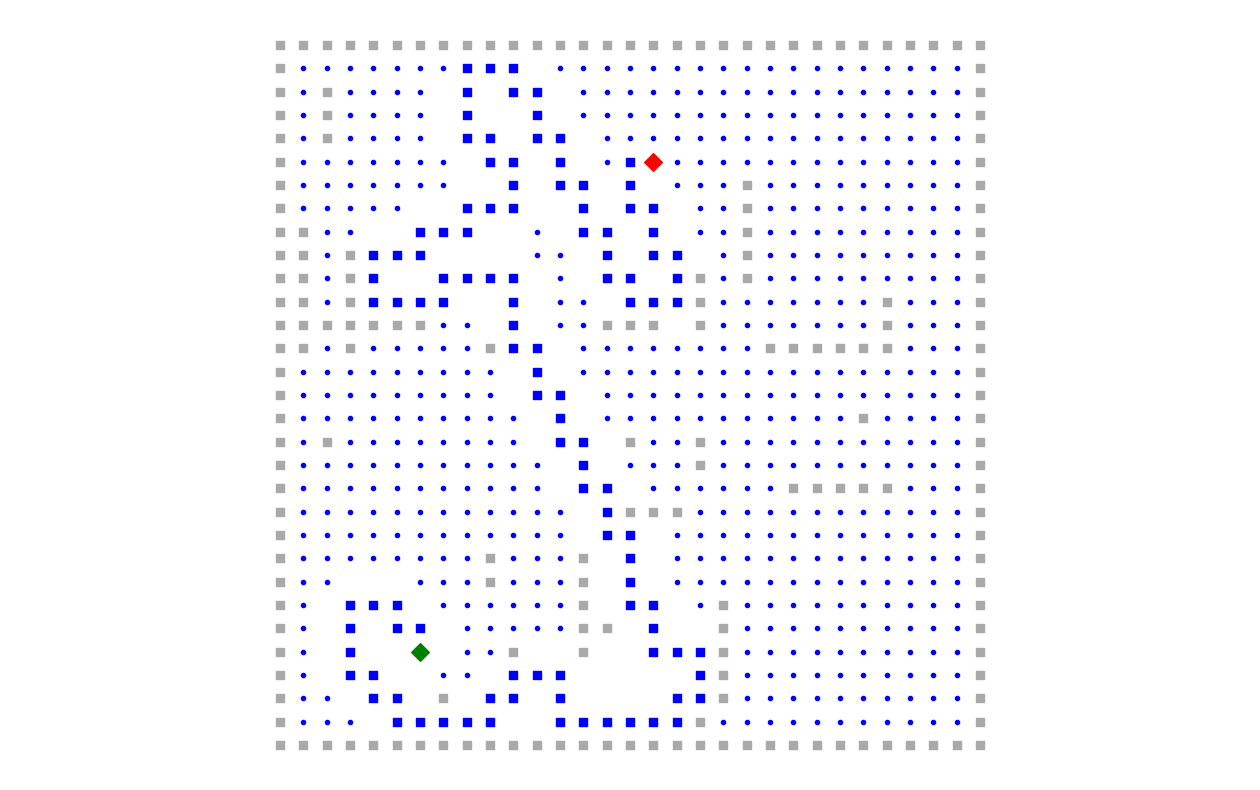

           Depth search search: 109.0 path cost, 661 states reached


In [9]:
# %load -r 43-44 grid_from_origin_destine.py
problem = GridProblem(initial=(6,4), goal=(16,25), obstacles=random_lines(X=range(27), Y=range(27), N=25, lengths=range(1,6)) | frame)
solution_depth_first = depth_first_graph_search(problem)
problem.plot_grid_problem(solution_depth_first, 'Depth search')

###### Búsqueda en Anchura

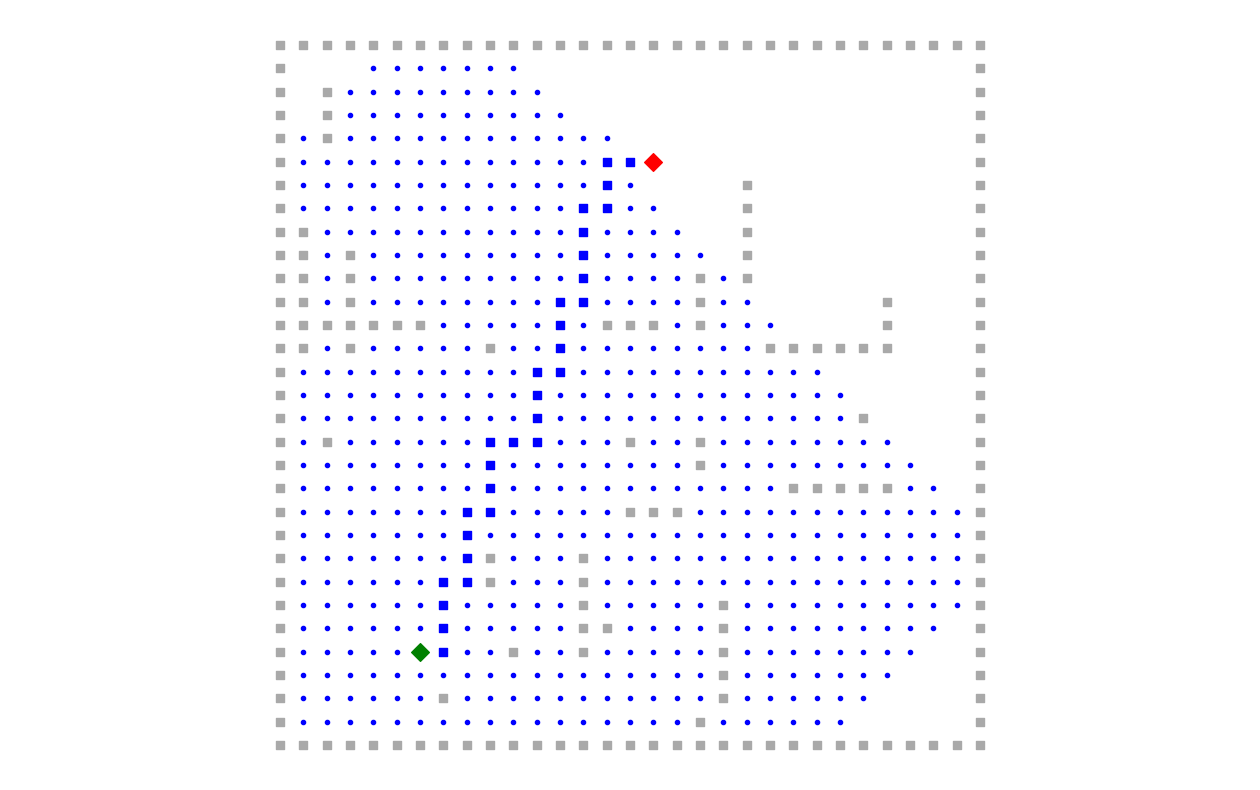

           Breadth search search: 31.0 path cost, 577 states reached


In [10]:
# %load -r 40-42 grid_from_origin_destine.py
solution_breadth_first = breadth_first_graph_search(problem)
problem.plot_grid_problem(solution_breadth_first, 'Breadth search')

###### Búsqueda de Coste Uniforme

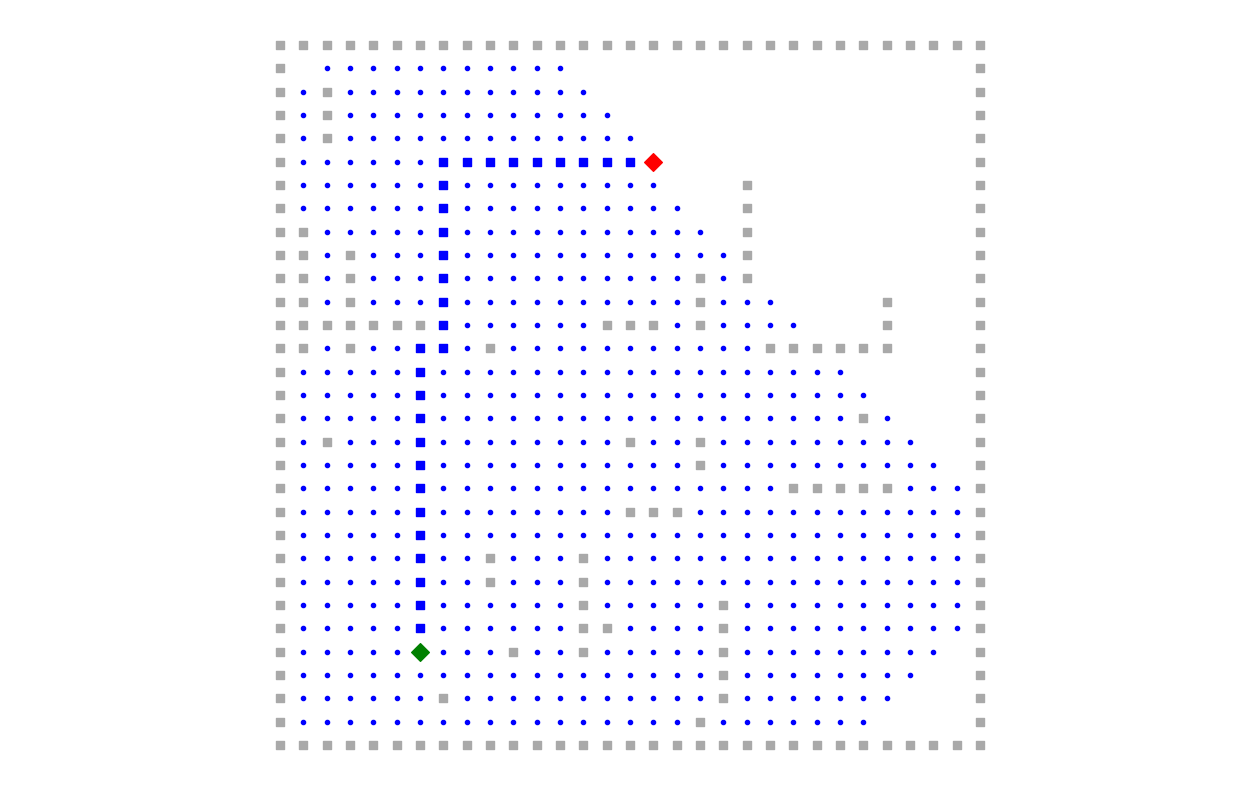

           Uniform search search: 31.0 path cost, 605 states reached


In [11]:
# %load -r 45-46 grid_from_origin_destine.py
solution_uniform_cost = uniform_cost_search(problem)
problem.plot_grid_problem(solution_uniform_cost, 'Uniform search')